# Neural style transfer

This notebook demonstrates the original style-transfer algorithm to compose one image in the style of another image. This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.
 
The notebook is adapted from [Tensorflow neural style transfer tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer).

## Import and configure modules

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [18]:
# Choose a style image and a content image:
content_path = "images/amsterdam.jpg"
style_path = "images/fox_painting.jpg"

## Visualize the input

In [ ]:
# Define a function to load an image and limit its maximum dimension to 512 pixels
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Create a simple function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This notebook demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. But before doing that, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

2022-08-27 15:40:43.074458: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-27 15:40:43.081714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


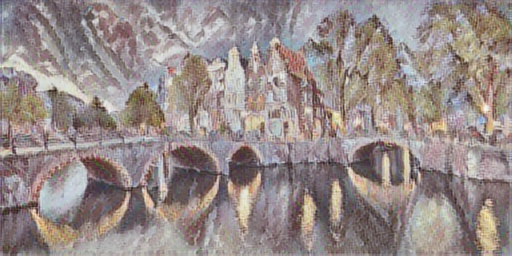

In [22]:
import tensorflow_hub as hub
os.environ['TFHUB_CACHE_DIR'] = '/Users/thuvu/Documents/projects/Link/lib/python3.9/site-packages/tensorflow'
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations using VGG19

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, we are using the [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


### Test run a VGG19 on our image to ensure it's used correctly

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19()
prediction_probabilities = vgg(x)

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

### Choose intermediate layers to represent the style & content of the image

In [ ]:
# Now load a `VGG19` without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)
    
# Choose intermediate layers from the network to represent the style and content of the image:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

### Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Extract style and content


In [ ]:
# Functions that returns a list of intermediate layer outputs using a VGG19 model:
def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


# Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

## Run gradient descent

With this style and content extractor, we can now implement the style transfer algorithm. Do this by calculating the mean square error for the image's output relative to each target, then take the weighted sum of these losses.

In [ ]:
# When called on an image, this StyleContentModel model returns the gram matrix (style) 
# of the style_layers and content of the content_layers:
extractor = StyleContentModel(style_layers, content_layers)

# Set style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize.
image = tf.Variable(content_image)

# Define weights for style closs and content loss:
style_weight=1e-2
content_weight=1e4

# Function to calculate total loss as combination of the two losses
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight /  num_content_layers
    loss = style_loss + content_loss
    return loss

### (1) Training function - Basic implementation

In [ ]:
# Function to keep the image's pixel values between 0 and 1:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Create an optimizer, in this example we use Adam
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Training function. Use tf.GradientTape to update the image.
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

### Test run for training function

In [ ]:
# Now run a few steps to test if it's working, before performing a longer optimization::
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

### Run optimization

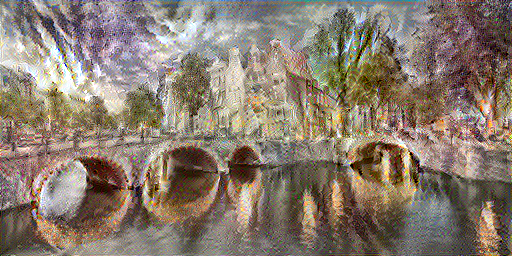

Train step: 700
Total time: 85.5


INFO:tensorflow:Assets written to: ram://894fd24e-4bf9-4021-9f1d-e68a1c9c38bb/assets


INFO:tensorflow:Assets written to: ram://894fd24e-4bf9-4021-9f1d-e68a1c9c38bb/assets


INFO:tensorflow:Assets written to: ram://f2dcce6d-0d17-4750-a4f3-dd6880e9253f/assets


INFO:tensorflow:Assets written to: ram://f2dcce6d-0d17-4750-a4f3-dd6880e9253f/assets


INFO:tensorflow:Assets written to: ram://84aee8ea-0a3c-4fb5-8b2b-637755556783/assets


INFO:tensorflow:Assets written to: ram://84aee8ea-0a3c-4fb5-8b2b-637755556783/assets


INFO:tensorflow:Assets written to: ram://dd1d9d93-8de6-4e74-bf9e-e689f897ce56/assets


INFO:tensorflow:Assets written to: ram://dd1d9d93-8de6-4e74-bf9e-e689f897ce56/assets


INFO:tensorflow:Assets written to: ram://b68c7e05-bcc9-4b1d-a0bb-b7b56b4c6963/assets


INFO:tensorflow:Assets written to: ram://b68c7e05-bcc9-4b1d-a0bb-b7b56b4c6963/assets


In [24]:
start = time.time()

epochs = 7
steps_per_epoch = 100

step = 0
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [18]:
# Save the result:
file_name = 'images/stylized-image.png'
tensor_to_image(image).save(file_name)

### (2) Training function - Implementing Total variation loss (OPTIONAL)

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [19]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

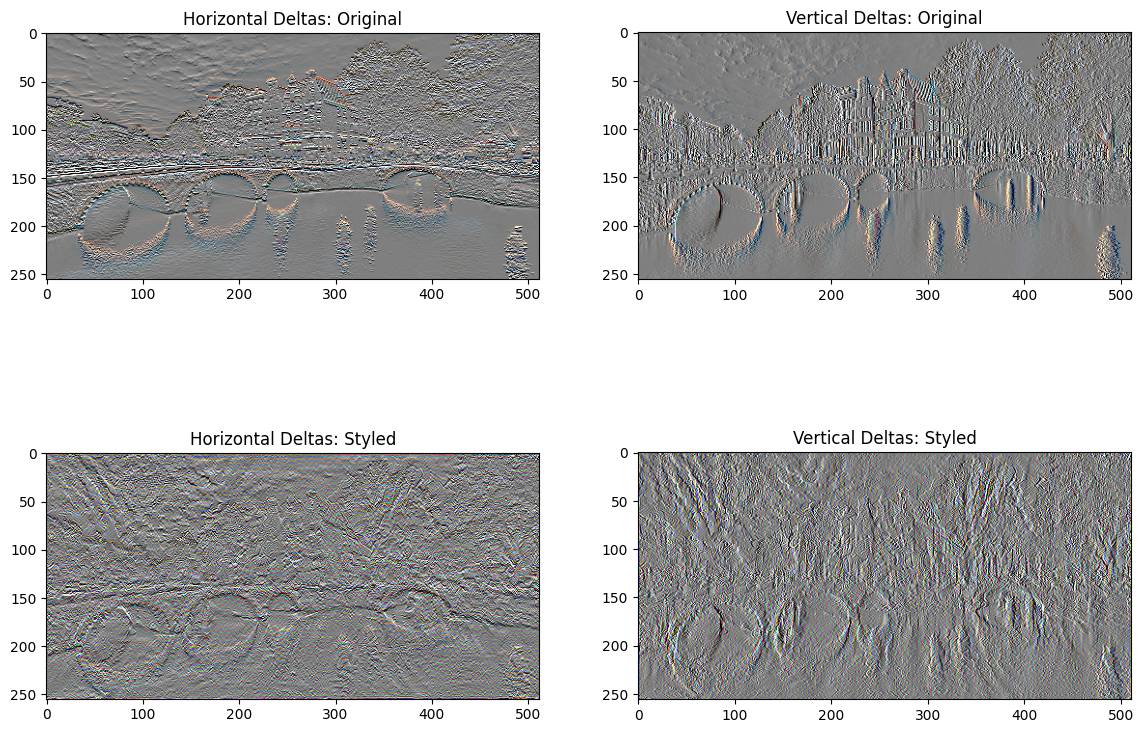

In [20]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

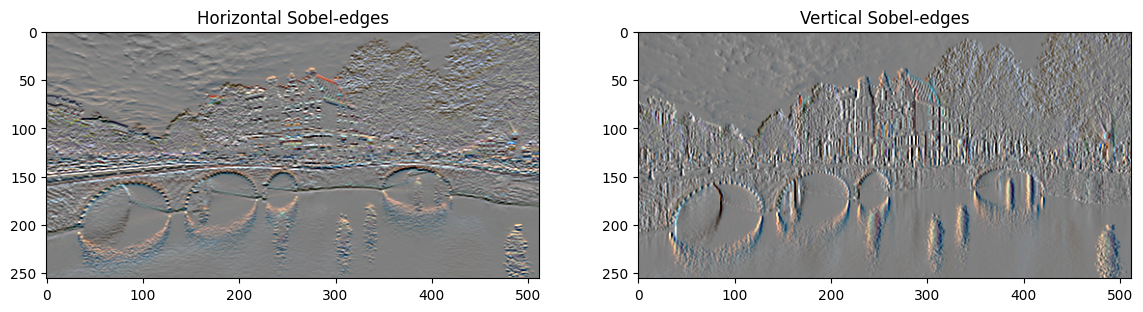

In [21]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [22]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

84315.66

This implementation is equivalent to the following TensorFlow's standard implementation:

In [23]:
tf.image.total_variation(image).numpy()

array([84315.66], dtype=float32)

### Re-run the optimization

In [24]:
# Choose a weight for the total_variation_loss and include it in the train_step function:
total_variation_weight=30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

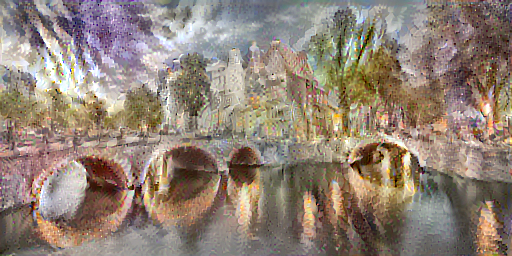

Train step: 700
Total time: 77.9


In [25]:
# Reinitialize the optimization variable:
image = tf.Variable(content_image)

# And run the optimization:
start = time.time()

epochs = 7
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [26]:
# Finally, save the result:
file_name = 'images/stylized-image-variation-loss.png'
tensor_to_image(image).save(file_name)